# Predicting the Category of a Jeopardy! Question using Logistic Regression

In [1]:
!pip install portalocker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import torchtext
import torchdata
import portalocker
import json
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
filename = 'gdrive/MyDrive/Colab Notebooks/JEOPARDY_CSV.csv'

with open(filename, 'r', encoding='iso-8859-1') as f:
    df = pd.read_csv(f)

In [4]:
df = df[[' Category', ' Question']]
df = df.rename(columns={' Question': 'Question',' Category': 'Category'})
df = df.sample(frac=0.8,random_state=200)

In [5]:
most_common_cat_count = df['Category'].value_counts().nlargest(4)
most_common_cat_count

BEFORE & AFTER      440
SCIENCE             428
LITERATURE          394
AMERICAN HISTORY    324
Name: Category, dtype: int64

In [6]:
most_common_cat = most_common_cat_count.index.tolist()
df = df[df['Category'].isin(most_common_cat)]
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['Category'].apply(lambda x: encode_cat(x))
df['ENCODE_CAT'].unique()

<ipython-input-6-aaf53764c5d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ENCODE_CAT'] = df['Category'].apply(lambda x: encode_cat(x))


array([0, 1, 2, 3])

In [7]:
df['Question'] = df['Question'].replace("'","")

# create (label, question) pairs
examples_categories = list(zip(df.ENCODE_CAT, df.Question))
examples_categories[0]

(0, 'John Gotti nickname for the Man of La Mancha')

In [8]:
def get_text(pairs):
    '''
    From each label-text pair, extract the text
    and compile into a string to feed into the vocabulary.
    '''
    text = list(map(lambda x: x[1], pairs))
    res = ' '.join(text)
    return res

t = get_text(examples_categories)

In [9]:
class JeopardyData(Dataset):
    def __init__(self, examples=list, vocabulary = None):
        '''
        Create a dataset of examples (list of tuples), with each example being
        a tuple (label, text)
        '''
        self.examples = examples
        self.text = get_text(examples)
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                map(get_tokenizer('basic_english'), self.text),
                specials=['<unk>'])
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary
    
    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

In [10]:
categories_data = JeopardyData(examples_categories)

In [11]:
vocab = categories_data.get_vocab()

In [12]:
from torch.utils.data import DataLoader

tokenizer = get_tokenizer('basic_english')

def collate_into_bow(batch):
    labels = []
    bow_vectors = []
    for label, text in batch:
        labels.append(label)
        bow_vector = [0.0] * len(vocab)
        tokens = tokenizer(text)
        for t in tokens:
            t_idx = vocab[t]
            bow_vector[t_idx] += 1
        bow_vector = [x / len(tokens) for x in bow_vector]
        bow_vectors.append(bow_vector)
    result = (torch.tensor(labels), torch.tensor(bow_vectors))

    return result

### BOW Classifier

In [13]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

### Create function to train one epoch

In [14]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

### Create function to compute accuracy

In [15]:
def get_accuracy(dataloader):
    model.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy

In [21]:
from torch.utils.data.dataset import random_split

train_size = int(0.8*len(df))
val_size = int(0.1*len(df))
test_size = int(0.1*len(df))

BATCH_SIZE = 64

train_data, valid_data, test_data = random_split(categories_data.examples, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

In [20]:
num_labels = len(df.ENCODE_CAT.unique())
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

### Training


After epoch 1 the validation accuracy is 0.214.


After epoch 2 the validation accuracy is 0.289.


After epoch 3 the validation accuracy is 0.252.


After epoch 4 the validation accuracy is 0.270.


After epoch 5 the validation accuracy is 0.365.


After epoch 6 the validation accuracy is 0.270.


After epoch 7 the validation accuracy is 0.220.


After epoch 8 the validation accuracy is 0.270.


After epoch 9 the validation accuracy is 0.377.


After epoch 10 the validation accuracy is 0.365.


After epoch 11 the validation accuracy is 0.302.


After epoch 12 the validation accuracy is 0.283.


After epoch 13 the validation accuracy is 0.333.


After epoch 14 the validation accuracy is 0.327.


After epoch 15 the validation accuracy is 0.340.


After epoch 16 the validation accuracy is 0.333.


After epoch 17 the validation accuracy is 0.377.


After epoch 18 the validation accuracy is 0.384.


After epoch 19 the validation accuracy is 0.384.


After epoch 20 the validation accuracy 

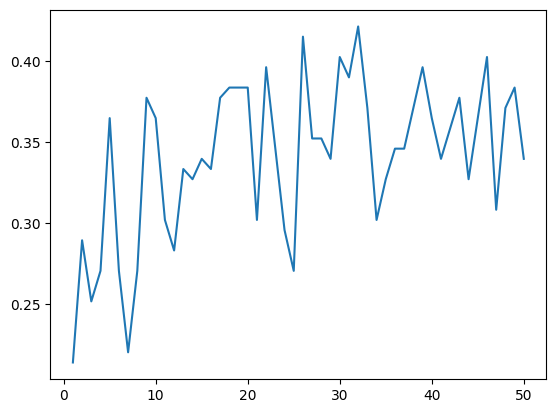

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 50 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [23]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 50 epochs:", test_accuracy)

test accuracy from model trained on 50 epochs: 0.3227848101265823
